<a href="https://colab.research.google.com/github/solong96/solong96/blob/main/0824_cc_text_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers.rnn import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout, Embedding
from keras.layers.normalization import batch_normalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import gzip
import os

In [4]:
path = '/content/drive/MyDrive/'
os.chdir(path)

In [5]:
index_list = list(range(0,8,1))
word = pd.DataFrame({'cate':["energy","industry","waste","traffic","building","green","biodiversity","water"],
                                    'toxic':[11,12,13,14,15,21,22,23],
                                    'class':index_list})
word

,cate,toxic,class
0,energy,11,0
1,industry,12,1
2,waste,13,2
3,traffic,14,3
4,building,15,4
5,green,21,5
6,biodiversity,22,6
7,water,23,7


In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.40.17.114:8470
REPLICAS:  8


In [7]:
# train_dataset = pd.read_excel('0818_cc_train_token_title.xlsx')
train_dataset = pd.read_excel('0824_cc_train_token_abstract2.xlsx')
train_dataset

,Unnamed: 0,Abstract,token,category,toxic
0,0,The urban heat island effect (UHI) is a produc...,urban heat-island UHU product urbanization cer...,green,21
1,1,Global warming is increasing extreme heat cond...,global extreme heat condition energy efficienc...,energy,11
2,2,Renewable energy is considered crucial for cli...,renewable energy crucial climate-change mitiga...,energy,11
3,3,Coastal groundwater-dependent ecosystems (GDEs...,coastal groundwater-dependent ecosystem gde we...,water,23
4,4,Reductions in carbon emissions have been a foc...,reduction carbon-emission focus power sector s...,energy,11
...,...,...,...,...,...
13166,13166,Electrochemical batteries are essential for re...,electrochemical battery essential renewable su...,energy,11
13167,13167,Many cities across the United States have turn...,many city united state energy disclosure bench...,energy,11
13168,13168,There is a compelling body of evidence calling...,body reduction amount carbon dioxide CO2 manki...,energy,11
13169,13169,This paper presents a multi-criteria optimizat...,present multi-criterion optimization power sys...,energy,11


In [8]:
train = train_dataset[['token','toxic']]
train

,token,toxic
0,urban heat-island UHU product urbanization cer...,21
1,global extreme heat condition energy efficienc...,11
2,renewable energy crucial climate-change mitiga...,11
3,coastal groundwater-dependent ecosystem gde we...,23
4,reduction carbon-emission focus power sector s...,11
...,...,...
13166,electrochemical battery essential renewable su...,11
13167,many city united state energy disclosure bench...,11
13168,body reduction amount carbon dioxide CO2 manki...,11
13169,present multi-criterion optimization power sys...,11


In [9]:
xtrain, xvalid, y_train, y_valid = train_test_split(train.token.values, train.toxic.values,
                                                  stratify=train.toxic.values,
                                                  random_state=42,
                                                  test_size=0.2, shuffle=True)

In [10]:
print(pd.Series(xtrain).apply(lambda x:len(str(x).split())).max())
max_len = (round(pd.Series(xtrain).apply(lambda x:len(str(x).split())).max()/100)*100)+50
print(max_len)

1034
1050


In [11]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
# max_len = 1000

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [12]:
# Calculating the Vocabulary Size and the number of Answers

print("Vocabulary size={}".format(len(token.word_index)))
print("Number of Answers={}".format(token.document_count))

Vocabulary size=27650
Number of Answers=13171


In [13]:
le = LabelEncoder()
num_classes=8

# 0          energy
# 1        industry
# 2           waste
# 3         traffic
# 4        building
# 5        land-use
# 6           green
# 7    biodiversity
# 8           water
# 9     heat island

ytrain = le.fit_transform(y_train)
yvalid = le.transform(y_valid)

ytrain = to_categorical(ytrain)
yvalid = to_categorical(yvalid)

In [14]:
ytrain

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [15]:
ytrain.shape

(10536, 8)

# Word Embeddings

While building our simple RNN models we talked about using word-embeddings , So what is word-embeddings and how do we get word-embeddings?
Here is the answer :
* https://www.coursera.org/learn/nlp-sequence-models/lecture/6Oq70/word-representation
* https://machinelearningmastery.com/what-are-word-embeddings/
<br> <br>
The latest approach to getting word Embeddings is using pretained GLoVe or using Fasttext. Without going into too much details, I would explain how to create sentence vectors and how can we use them to create a machine learning model on top of it and since I am a fan of GloVe vectors, word2vec and fasttext. In this Notebook, I'll be using the GloVe vectors. You can download the GloVe vectors from here http://www-nlp.stanford.edu/data/glove.840B.300d.zip or you can search for GloVe in datasets on Kaggle and add the file

In [18]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}

# f = open('glove.6B.300d.txt','r',encoding='utf-8')
with gzip.open('glove.6B.300d.gz','rb') as f:
  for line in tqdm(f):
    encode = line.decode('utf-8')
    values = encode.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
  f.close()

print('Found %s word vectors.' % len(embeddings_index))

400001it [01:13, 5456.22it/s]

Found 400001 word vectors.


In [17]:
embeddings_index['the']

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

1D CNN

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300)) # 300은 차원 수
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 27678/27678 [00:00<00:00, 208669.52it/s]


In [16]:
dict(zip(list(le.classes_), le.transform(list(le.classes_))))

{11: 0, 12: 1, 13: 2, 14: 3, 15: 4, 21: 5, 22: 6, 23: 7}

In [ ]:
from keras.models import Model
from keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate

kernel_sizes = [2, 3, 5]
num_filters = 512
dropout_ratio = 0.5

vocab_size = len(word_index) + 1
label_idx = dict(zip(list(le.classes_), le.transform(list(le.classes_))))

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for size in kernel_sizes:
    conv = Conv1D(filters=num_filters,
                         kernel_size=size,
                         padding="valid",
                         activation="relu",
                         strides=1)(output)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

output = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
output = Dropout(dropout_ratio)(output)
model_output = Dense(len(label_idx), activation='softmax')(output)
model = Model(model_input, model_output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1050)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1050, 300)    8303700     ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 1049, 512)    307712      ['embedding_2[0][0]']            
                                                                                                  
 conv1d_7 (Conv1D)              (None, 1048, 512)    461312      ['embedding_2[0][0]']            
                                                                                            

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.00001)
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = model.fit(xtrain_pad, ytrain,
                              batch_size=64*strategy.num_replicas_in_sync,
                              epochs=10,
                              validation_data=(xvalid_pad, yvalid),
                              callbacks = [es, mc])

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.0429 - acc: 0.9914
Epoch 1: val_acc improved from -inf to 0.91247, saving model to best_model.hdf5
21/21 [==============================] - 116s 6s/step - loss: 0.0429 - acc: 0.9914 - val_loss: 0.2369 - val_acc: 0.9125
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.0356 - acc: 0.9935
Epoch 2: val_acc did not improve from 0.91247
21/21 [==============================] - 115s 5s/step - loss: 0.0356 - acc: 0.9935 - val_loss: 0.2433 - val_acc: 0.9094
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.0324 - acc: 0.9940
Epoch 3: val_acc did not improve from 0.91247
21/21 [==============================] - 115s 5s/step - loss: 0.0324 - acc: 0.9940 - val_loss: 0.2499 - val_acc: 0.9068
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 0.0296 - acc: 0.9943
Epoch 4: val_acc did not improve from 0.91247
21/21 [==============================] - 116s 6s/step - loss: 0.02

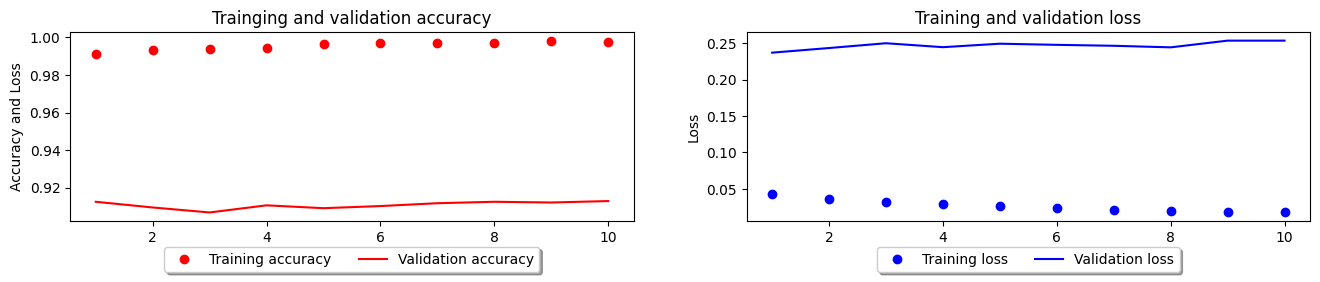

In [ ]:
import matplotlib.pyplot as plt

def show_graph(history):
    history_dict = history.history
    accuracy = history_dict['acc']
    val_accuracy = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(16, 1))

    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, -0.1))

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, 0))

    plt.show()
show_graph(history)

In [ ]:
yvalid_model = model.predict(xvalid_pad)
yvalid_model

83/83 [==============================] - 4s 40ms/step


array([[9.99979913e-01, 4.88451860e-06, 3.81386371e-08, ...,
        4.60230218e-08, 5.85878972e-08, 3.96234498e-07],
       [4.40412638e-04, 5.34889637e-04, 1.91271301e-05, ...,
        2.56469248e-05, 3.25444780e-05, 5.23966446e-06],
       [9.98118579e-01, 5.84556838e-05, 3.16325786e-05, ...,
        9.98979795e-06, 5.07713448e-05, 1.18025355e-05],
       ...,
       [9.99999046e-01, 3.11032380e-07, 6.32756922e-08, ...,
        2.05748023e-08, 3.37558077e-07, 5.01235000e-08],
       [4.68832813e-03, 2.78695495e-07, 1.01938049e-07, ...,
        8.46076276e-09, 1.74276167e-07, 4.24283400e-08],
       [5.82602527e-03, 5.51151782e-02, 9.07045178e-05, ...,
        8.17235996e-05, 3.60081249e-05, 7.00258679e-05]], dtype=float32)

0	energy
1	industry
2	waste
3	traffic
4	building
5	land-use
6	green
7	biodiversity
8	water
9	heat island

In [ ]:
#converting the one hot vector output to a linear numpy array.
yvalid_class = np.argmax(yvalid_model, axis = 1)

In [ ]:
index_list = range(0,10,1)
word = pd.DataFrame({'cate':["energy","industry","waste","traffic","building","land-use","green","biodiversity","water","heat island"],
                                    'toxic':[11,12,13,14,15,16,21,22,23,24],
                                    'class':index_list})
word

,cate,toxic,class
0,energy,11,0
1,industry,12,1
2,waste,13,2
3,traffic,14,3
4,building,15,4
5,land-use,16,5
6,green,21,6
7,biodiversity,22,7
8,water,23,8
9,heat island,24,9


In [ ]:
word[(word['toxic'] == y_valid[1])]['class'].values[0]

3

In [ ]:
y_valid_class = []
for i in range(len(y_valid)):
  y_valid_class.append(word[(word['toxic'] == y_valid[i])]['class'].values[0])

In [ ]:
y_valid[1], y_valid_class[1]

(14, 3)

In [ ]:
#extracting the classes from the label encoder
encoded_classes = le.classes_

#mapping the encoded output to actual categories
predicted_category = [encoded_classes[x] for x in yvalid_class]
true_category = [encoded_classes[x] for x in y_valid_class]

In [ ]:
result_df = pd.DataFrame({'description':xvalid,'true_category':true_category, 'predicted_category':predicted_category})
result_df.head()

,description,true_category,predicted_category
0,climate-change concerned environmental issue w...,11,11
1,main challenge transportation industry labor c...,14,14
2,study variance overall greenhouse gas mitigati...,11,11
3,various definition energy net-zero energy buil...,11,11
4,energy inevitable necessity human energy sourc...,11,11


In [ ]:
result_df.to_excel('0824_cc_CNN_result.xlsx')

In [ ]:
digital = pd.read_excel('0824_digital_train_token_abstract_4000.xlsx')
digital

,Unnamed: 0,Abstract,token,category,toxic
0,0,"The world is entering a new era, where Interne...",world new era internet-of-thing iot smart home...,building,15
1,1,The Internet of Things (IoT) is a paradigm cha...,internet thing iot paradigm characterize netwo...,waste,13
2,2,Internet of Things (IoT) enables Smart Cities ...,internet thing iot enable smart city SC novel ...,traffic,14
3,3,Smart city concepts have gained substantial at...,smart city concept substantial attention last ...,energy,11
4,4,Smartgrid is a paradigm that was introduced in...,smartgrid paradigm conventional electricity ne...,energy,11
...,...,...,...,...,...
4401,4401,Previous work has shown that the type and pH h...,previous work type ph history aerosol govern t...,water,23
4402,4402,Rail transport is one the prominent modes of t...,rail transport prominent mode transportation r...,traffic,14
4403,4403,Due to the significant environmental impact of...,due significant environmental power production...,energy,11
4404,4404,Background: The Distributed Energy Resources (...,distributed energy resource der beneficial ele...,energy,11


In [ ]:
print(digital['token'].apply(lambda x:len(str(x).split())).max())
max_len = (round(digital['token'].apply(lambda x:len(str(x).split())).max()/100)*100)+50
print(max_len)

280
350


In [ ]:
xtest = digital.token.values

# using keras tokenizer here
token = text.Tokenizer(num_words=None)
# max_len = 1000

token.fit_on_texts(list(xtest))
xtest_seq = token.texts_to_sequences(xtest)

#zero pad the sequences
xtest_pad = pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
ytest_model = model.predict(xtest_pad)
ytest_model

138/138 [==============================] - 3s 19ms/step


array([[9.9995655e-01, 1.8915969e-05, 6.8222778e-07, ..., 1.4576348e-06,
        3.0427732e-06, 9.5040332e-07],
       [1.7736386e-01, 6.4145126e-03, 7.5448523e-03, ..., 3.2189018e-03,
        1.7530091e-02, 1.7223707e-03],
       [3.9357580e-02, 1.7943474e-03, 2.4948840e-04, ..., 3.1003883e-04,
        8.8497009e-03, 1.9857439e-04],
       ...,
       [4.0156502e-01, 3.6195433e-04, 7.2738338e-05, ..., 6.4310771e-05,
        7.8531094e-02, 3.3485983e-05],
       [9.3550521e-01, 1.4303069e-04, 1.6111129e-05, ..., 3.3293454e-06,
        1.4518628e-04, 9.7968077e-06],
       [6.2567994e-02, 1.7873293e-02, 1.6670667e-03, ..., 1.1771409e-03,
        8.8857120e-01, 2.6836645e-04]], dtype=float32)

In [ ]:
print(xtest[0])
print(np.where(ytest_model[0] == np.max(ytest_model[0]))[0].item())

world new era internet-of-thing iot smart home smart city play important role meeting so-called big challenge near future foreseen majority world population live life smart home smart city support sustainable urban development quality life multi-disciplinary approach evident new advance information communication technology ICT infrastructure key feature smart vision propose specific solution form hierarchical ICT infrastructure handle ICT issue relate big challenge integrate iot smart home smart city structure coherent unit benefit infrastructure complex iot system simulation deal wastewater energy smart building smart city context simulation infrastructure able harvest wastewater energy smart residential building smart city infrastructure control harvest time duration possible achieve considerable energy savings home possible peak load district heating plant
0


In [ ]:
predict = {'token': [], 'class': [], 'true_cate': [], 'predict_cate': []}
for i in tqdm(range(len(xtest))):
  predict['token'].append(xtest[i])
  predict['class'].append(np.where(ytest_model[i] == np.max(ytest_model[i]))[0].item())
  predict['true_cate'].append(digital[(digital['token'] == xtest[i])]['category'].values[0])
  predict['predict_cate'].append(word[(word['class'] == np.where(ytest_model[i] == np.max(ytest_model[i]))[0].item())]['cate'].values[0])
predict = pd.DataFrame(predict)
predict

100%|██████████| 4406/4406 [00:07<00:00, 573.91it/s]


,token,class,true_cate,predict_cate
0,world new era internet-of-thing iot smart home...,0,building,energy
1,internet thing iot paradigm characterize netwo...,3,waste,traffic
2,internet thing iot enable smart city SC novel ...,3,traffic,traffic
3,smart city concept substantial attention last ...,0,energy,energy
4,smartgrid paradigm conventional electricity ne...,0,energy,energy
...,...,...,...,...
4401,previous work type ph history aerosol govern t...,8,water,water
4402,rail transport prominent mode transportation r...,3,traffic,traffic
4403,due significant environmental power production...,3,energy,traffic
4404,distributed energy resource der beneficial ele...,0,energy,energy


In [ ]:
pd.DataFrame(predict).to_excel('0824_digital_predict_4000.xlsx', index=False)

In [ ]:
predictions = model.predict(xtest_pad)
display(predictions.shape)

138/138 [==============================] - 3s 20ms/step


(4406, 10)

In [ ]:
np.sum(predictions[0])

0.99999994

In [ ]:
display(np.argmax(predictions[0]))
display(predictions[0][3])

0

5.2276027e-06

# LSTM's

## Basic Overview

Simple RNN's were certainly better than classical ML algorithms and gave state of the art results, but it failed to capture long term dependencies that is present in sentences . So in 1998-99 LSTM's were introduced to counter to these drawbacks.

## In Depth Understanding

Why LSTM's?
* https://www.coursera.org/learn/nlp-sequence-models/lecture/PKMRR/vanishing-gradients-with-rnns
* https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/

What are LSTM's?
* https://www.coursera.org/learn/nlp-sequence-models/lecture/KXoay/long-short-term-memory-lstm
* https://distill.pub/2019/memorization-in-rnns/
* https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

# Code Implementation

We have already tokenized and paded our text for input to LSTM's

In [19]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300)) # 300은 차원 수
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 27650/27650 [00:00<00:00, 221543.54it/s]


LSTM(n, input_dim = k, input_length = k)

n : 메모리 셀의 개수(기억용량, 출력형태를 결정함)

In [20]:
# %%time
with strategy.scope():

    # A simple LSTM with glove embeddings and one dense layer
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(8, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1050, 300)         8295300   
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 8,523,724
Trainable params: 228,424
Non-trainable params: 8,295,300
_________________________________________________________________


In [21]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_model_2.hdf5',             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss)
                              patience=10,         # 10회 Epoch동안 개선되지 않는다면 종료
                             )

history = model.fit(xtrain_pad, ytrain,
                              batch_size=64*strategy.num_replicas_in_sync,
                              epochs=100,
                              validation_data=(xvalid_pad, yvalid),
                              callbacks = [earlystopping, checkpoint])

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 1.4335 - accuracy: 0.5513
Epoch 1: val_loss improved from inf to 1.04436, saving model to best_model_2.hdf5
21/21 [==============================] - 21s 649ms/step - loss: 1.4335 - accuracy: 0.5513 - val_loss: 1.0444 - val_accuracy: 0.6455
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.8444 - accuracy: 0.7374
Epoch 2: val_loss improved from 1.04436 to 0.79599, saving model to best_model_2.hdf5
21/21 [==============================] - 4s 204ms/step - loss: 0.8444 - accuracy: 0.7374 - val_loss: 0.7960 - val_accuracy: 0.7962
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.8300
Epoch 3: val_loss improved from 0.79599 to 0.56109, saving model to best_model_2.hdf5
21/21 [==============================] - 4s 216ms/step - loss: 0.5901 - accuracy: 0.8300 - val_loss: 0.5611 - val_accuracy: 0.8414
Epoch 4/100
21/21 [==============================] - ETA: 0s - loss

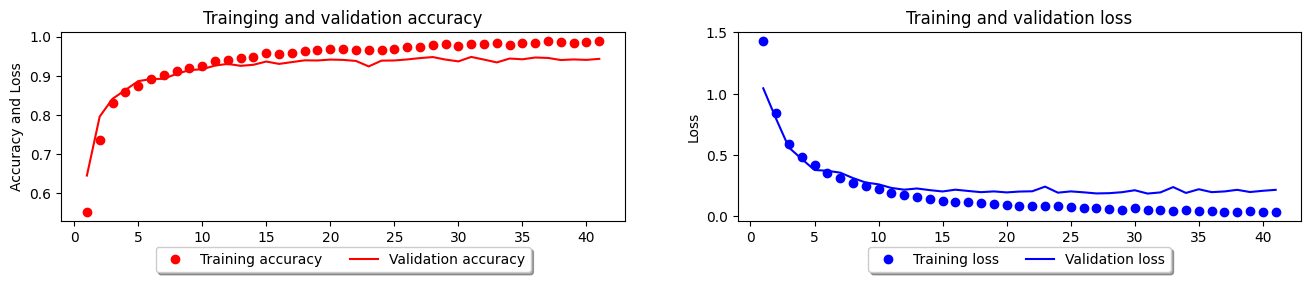

In [22]:
import matplotlib.pyplot as plt

def show_graph(history):
    history_dict = history.history
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(16, 1))

    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, -0.1))

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, 0))

    plt.show()
show_graph(history)

In [23]:
yvalid_model = model.predict(xvalid_pad)
yvalid_model

83/83 [==============================] - 6s 48ms/step


array([[9.99979377e-01, 1.76416643e-06, 7.00158864e-07, ...,
        1.25259601e-06, 3.16394960e-07, 1.15103978e-06],
       [9.99981523e-01, 4.58982640e-07, 2.34475419e-06, ...,
        3.10557789e-06, 8.11397030e-08, 2.61015703e-06],
       [9.92900550e-01, 3.40393817e-05, 2.20813467e-06, ...,
        2.59786248e-05, 4.16246985e-06, 1.21061885e-05],
       ...,
       [9.99725044e-01, 6.70696363e-06, 5.30332159e-07, ...,
        1.35443715e-05, 4.91435401e-07, 2.86078125e-06],
       [2.56630015e-02, 4.00422188e-03, 3.47882560e-05, ...,
        7.12419220e-04, 4.77335008e-04, 1.24465965e-04],
       [2.71337740e-05, 2.63278288e-08, 2.27379514e-05, ...,
        5.57580170e-05, 8.47948468e-06, 9.99814093e-01]], dtype=float32)

0	energy
1	industry
2	waste
3	traffic
4	building
5	land-use
6	green
7	biodiversity
8	water
9	heat island

In [24]:
#converting the one hot vector output to a linear numpy array.
yvalid_class = np.argmax(yvalid_model, axis = 1)

In [25]:
index_list = range(0,8,1)
word = pd.DataFrame({'cate':["energy","industry","waste","traffic","building","green","biodiversity","water"],
                                    'toxic':[11,12,13,14,15,21,22,23],
                                    'class':index_list})
word

,cate,toxic,class
0,energy,11,0
1,industry,12,1
2,waste,13,2
3,traffic,14,3
4,building,15,4
5,green,21,5
6,biodiversity,22,6
7,water,23,7


In [26]:
word[(word['toxic'] == y_valid[1])]['class'].values[0]

0

In [27]:
y_valid_class = []
for i in range(len(y_valid)):
  y_valid_class.append(word[(word['toxic'] == y_valid[i])]['class'].values[0])

In [28]:
y_valid[1], y_valid_class[1]

(11, 0)

In [29]:
#extracting the classes from the label encoder
encoded_classes = le.classes_

#mapping the encoded output to actual categories
predicted_category = [encoded_classes[x] for x in yvalid_class]
true_category = [encoded_classes[x] for x in y_valid_class]

In [30]:
result_df = pd.DataFrame({'description':xvalid,'true_category':true_category, 'predicted_category':predicted_category})
result_df.head()

,description,true_category,predicted_category
0,decarbonization deployment low-carbon technolo...,11,11
1,radiofrequency magnetic particle promise effic...,11,11
2,study comparative environmental life cycle ass...,11,11
3,carbon-emission prime reason global warming va...,14,14
4,building energy consumption carbon-emission de...,15,11


In [31]:
result_df.to_excel('0824_cc_LSTM_result_8.xlsx')

In [32]:
digital = pd.read_excel('0824_digital_train_token_abstract3.xlsx')
digital

,Unnamed: 0,Abstract,token,category,toxic
0,0,With the substantial social and environmental ...,substantial social environmental change global...,energy,11
1,1,"Globally, a dramatic demographic shift towards...",dramatic demographic shift urbanization propor...,green,21
2,2,Understanding how smart city investment influe...,smart city investment influence environment va...,green,21
3,3,"In the last ten years of economic disease, arc...",last ten year economic disease architect engin...,building,15
4,4,"The world is entering a new era, where Interne...",world new era internet-of-thing iot smart home...,building,15
...,...,...,...,...,...
11341,11341,The sharing economy is a very dynamic research...,economy dynamic area different context enable ...,traffic,14
11342,11342,Recent years have witnessed considerable progr...,recent year considerable progress application ...,traffic,14
11343,11343,Introduction The total demand for freight tran...,introduction total demand transport europe rec...,traffic,14
11344,11344,Transportation networks are fundamental to the...,transportation network fundamental efficient s...,traffic,14


In [33]:
print(digital['token'].apply(lambda x:len(str(x).split())).max())
max_len = (round(digital['token'].apply(lambda x:len(str(x).split())).max()/100)*100)+50
print(max_len)

411
450


In [34]:
xtest = digital.token.values

# using keras tokenizer here
token = text.Tokenizer(num_words=None)
# max_len = 1000

token.fit_on_texts(list(xtest))
xtest_seq = token.texts_to_sequences(xtest)

#zero pad the sequences
xtest_pad = pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

In [35]:
ytest_model = model.predict(xtest_pad)
ytest_model

355/355 [==============================] - 11s 26ms/step


array([[9.9999487e-01, 1.6701709e-07, 9.1325643e-07, ..., 2.5882227e-06,
        7.7238866e-08, 4.1622658e-07],
       [9.9650717e-01, 1.1498730e-05, 2.0115424e-06, ..., 6.8355577e-05,
        1.0966897e-05, 4.4281493e-05],
       [9.9998999e-01, 4.0478065e-07, 1.7513989e-06, ..., 3.7410107e-06,
        5.9569455e-08, 2.2767321e-07],
       ...,
       [5.0636340e-06, 2.7924114e-07, 4.7069435e-08, ..., 4.3258416e-07,
        2.9351577e-06, 2.5231730e-06],
       [9.9999177e-01, 1.0206523e-07, 1.0681200e-06, ..., 1.5536182e-06,
        2.1126144e-08, 1.9882457e-06],
       [5.7022102e-05, 1.0761893e-06, 4.4526138e-07, ..., 8.9836294e-06,
        2.9171892e-06, 3.2903936e-05]], dtype=float32)

In [36]:
print(xtest[0])
print(np.where(ytest_model[0] == np.max(ytest_model[0]))[0].item())

substantial social environmental change global level number city infrastructure strategy sustainable mobility policy stock energy renewable energy production waste management ICT infrastructure greater part heat electricity source high level integration household business industry utility smart city energy system article comprehensive methodology plan creation smart power system lead complex network energy supply technology diverse on-site off-site resource internet thing smart green energy iot-sge smart city implementation iot smart city energy pervasive monitoring secure communication article focus iot-based smart energy management system deep reinforcement finding outcome show iot sensor detect energy consumption energy demand smart city cost-saving
0


In [37]:
predict = {'token': [], 'class': [], 'true_cate': [], 'predict_cate': []}
ytest = []
for i in tqdm(range(len(xtest))):
  predict['token'].append(xtest[i])
  predict['class'].append(np.where(ytest_model[i] == np.max(ytest_model[i]))[0].item())
  predict['true_cate'].append(digital[(digital['token'] == xtest[i])]['category'].values[0])
  predict['predict_cate'].append(word[(word['class'] == np.where(ytest_model[i] == np.max(ytest_model[i]))[0].item())]['cate'].values[0])
predict = pd.DataFrame(predict)
predict

100%|██████████| 11346/11346 [00:51<00:00, 221.52it/s]


,token,class,true_cate,predict_cate
0,substantial social environmental change global...,0,energy,energy
1,dramatic demographic shift urbanization propor...,0,green,energy
2,smart city investment influence environment va...,0,green,energy
3,last ten year economic disease architect engin...,0,building,energy
4,world new era internet-of-thing iot smart home...,0,building,energy
...,...,...,...,...
11341,economy dynamic area different context enable ...,3,traffic,traffic
11342,recent year considerable progress application ...,0,traffic,energy
11343,introduction total demand transport europe rec...,3,traffic,traffic
11344,transportation network fundamental efficient s...,0,traffic,energy


In [38]:
pd.DataFrame(predict).to_excel('0824_digital_predict3.xlsx', index=False)

In [39]:
predictions = model.predict(xtest_pad)
display(predictions.shape)

355/355 [==============================] - 8s 21ms/step


(11346, 8)

In [45]:
ytest = le.fit_transform(digital.toxic.values)
ytest = to_categorical(ytest)

In [46]:
scores = model.evaluate(xtest_pad, ytest)
print("Accuracy: %.2f%%" % (scores[1]*100))

355/355 [==============================] - 15s 33ms/step - loss: 4.3485 - accuracy: 0.5123
Accuracy: 51.23%
